This notebook is used to process the data in format usable by training models.

In [1]:
import numpy as np
from scipy import io
from scipy.fftpack import fft, fftfreq


In [2]:
def load_matlab_file(file_path):
    mat = io.loadmat(file_path)
    data = mat['v']
    return np.asarray(data, dtype=np.float32)

data = [load_matlab_file(f'OriginalData/T{i:04d}.mat') for i in range(1, 1159)]
data = np.squeeze(np.stack(data), axis=2)

target = np.asarray(io.loadmat('OriginalData/key.mat')['key'], dtype=np.int8).flatten()

Our signal has a significant DC component. We remove it by `detrend` method from SciPy.

In [3]:
from scipy.signal import detrend

data = detrend(data, axis=1)

To minimise spectral leakage we use Hann windowing, as it provides good enough leackage protecting while giving better resolution than Hamming.

In [4]:
from scipy.signal import get_window

window = get_window('hann', data.shape[1])
data = data * window

We'll create a new dataframe to store FFT data for each vibration signal.

In [5]:
fft_freq = fftfreq(data.shape[1])

fft_data = np.abs(fft(data, axis=1))
fft_data = fft_data[:, fft_freq >= 0]
fft_freq = fft_freq[fft_freq >= 0]

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling
    ('pca', PCA(n_components=0.95)),  # PCA
    ('clf', RandomForestClassifier())  # Random Forest
])

# Perform cross-validation
scores = cross_val_score(pipeline, fft_data, target, cv=5)  # 5-fold cross-validation
print(f"Cross-Validation Scores: {scores}")
print(f"Mean Cross-Validation Score: {scores.mean()}")

Cross-Validation Scores: [1.         1.         1.         0.99134199 1.        ]
Mean Cross-Validation Score: 0.9982683982683984


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       865
           1       1.00      1.00      1.00       293

    accuracy                           1.00      1158
   macro avg       1.00      1.00      1.00      1158
weighted avg       1.00      1.00      1.00      1158



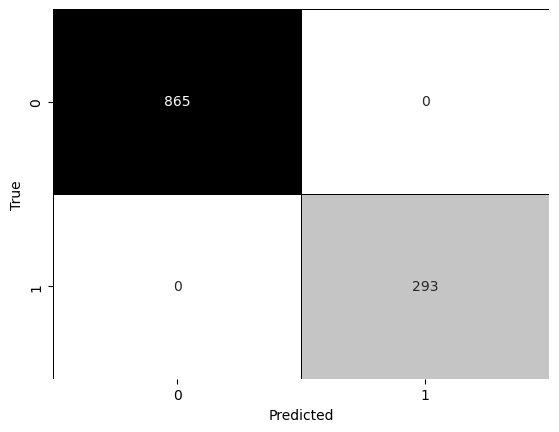

In [9]:
# Precision, Recall, F1-Score
from sklearn.metrics import classification_report

pipeline.fit(fft_data, target)
predicted = pipeline.predict(fft_data)
print(classification_report(target, predicted))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(target, predicted)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greys', cbar=False, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [12]:
# Save the model
import joblib

joblib.dump(pipeline, 'model.joblib')

['model.joblib']

In [6]:
# Load the model
import joblib
pipeline = joblib.load('model.joblib')

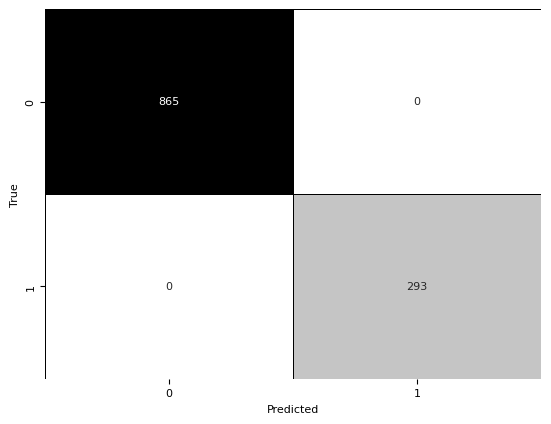

In [7]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 8})

predicted = pipeline.predict(fft_data)

conf_matrix = confusion_matrix(target, predicted)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greys', cbar=False, linewidths=0.5, linecolor='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
